# CIV1498 - Introduction to Data Science
## Project - Toronto Bike Share
## PART II: Eploratory Data Analysis
### By: Gneiss Data (Greig Knox and Yoko Yanagimura)

In this section, we will work with the cleaned and merged bike station and weather data derived from Part I. We will explore the dataset to extract insights that will help answer some of the questions posed by the City of Toronto. 

The list below shows the questions that were posed by the City of Toronto. We aim to answer the following questions through the analyses presented in this notebook:

1. Is there an increasing trend of usage from 2017 to 2020 and is the trend the same for both Casual and Annual Member riders?

2. Is there a difference in usage behaviour between Casual and Annual Member riders?

3. Which neighbourhoods have seen the largest number of rides depart from bike stations located within their boundaries?

4. Which neighbourhoods have seen the largest number of rides end at bike stations located within their boundaries?

5. How popular is FREE RIDE WEDNESDAYS?

6. How does the weather change the way people use the bike share system?

7. What weather features are most influential (temperature, humidity, precipitation, etc.)?

8. When are people using the bike share system? How does usage vary across the year, the week, and the day?

9. How did usage change in 2020 due to the pandemic and government-mandated lockdowns?

10. How do statutory holidays impact demand?

We have also conducted a series of analyses to provide some of our own insights into the dataset. We have attempted to answer the following questions through our analyses:

1. Does bike-share usage vary depending on proximity to TTC subway and streetcar stations?

2. Are there seasonal or geographic trends in trip duration?

3. If everyone is travelling along bike paths, which bike paths are the most congested and at what times of the day?

4. Are people using the bike-share system to access TTC stations?

5. How are people using the system, is it to commute to work or to explore the city?

## 0. Setup Notebook and Import Data

In [128]:
# Import 3rd party libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pytz
import fuzzywuzzy
from fuzzywuzzy import process
import chardet
import string
import datetime
import geopandas as gpd
import folium

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Centre all the charts displayed in this notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;
}
</style>
""")

We will import the cleaned bike trip dataset that will be used for analysis. 

In [2]:
#Import cleaned bike trip data
df_trips_data=pd.read_csv('df_merged_data.csv')
df_trips_data.set_index(keys='trip_id', drop=True, inplace=True)
df_trips_data.head()

,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,...,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
trip_id,,,,,,,,,,,,,,,,,,,,,
712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day


In [3]:
#backup of the dataframe
df_trips_data2=df_trips_data.copy()

In [4]:
#df_trip_data=df_trips_data2

# 1. Understanding the Dataset

Before diving into the analysis, it is important to understand and define the following properties about our dataset. 
1. Structure - what is the format of our data file?

2.  Granularity - how fine or coarse is each row and column?

3. Scope - how complete is our data set?

Some of these questions were already explored in the Part I (Data Cleaning and Wrangling), but we would like to reiterate the subject in more details in this section. 

### Structure

The structure of the datafile can be examined by looking at the "shape". We can see that there are 7924851 rows and 32 columns. 

In [5]:
df_trips_data.shape

(8007423, 31)

What are the fields (e.g. columns) in each record? What is the type of each column? We can use .columns to examine this. We can see that there data about the trip and the associated information about the weather when the trip was taken. We joined the bike trip data and the weather dataframe together in Part I. 

In [6]:
df_trips_data.columns

Index(['subscription_id', 'trip_duration', 'start_station_id', 'start_time',
       'start_station_name', 'end_station_id', 'end_time', 'end_station_name',
       'bike_id', 'user_type', 'start_station_name_npl',
       'end_station_name_npl', 'start_station_lat', 'start_station_lon',
       'end_station_lat', 'end_station_lon', 'merge_time', 'year', 'month',
       'day', 'time', 'temp_c', 'dew_point_temp_c', 'rel_hum_',
       'wind_dir_10s_deg', 'wind_spd_kmh', 'visibility_km', 'stn_press_kpa',
       'hmdx', 'wind_chill', 'weather'],
      dtype='object')

To summarize the data cleaning conducted in Part I, the records removed from the dataset include:

- Trip records outside the January 1, 2017 and October 31, 2020 range 
- Trip records with extreme and unrealistic trip durations based on the inter-quartile range
- Trip records with unknown start or end locations (i.e. missing station name and station id)
- Trip records with start or end stations not included in the provided bike station dataset (i.e. unknown start and end coordinates)



In [7]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
subscription_id,3199754,40.0
trip_duration,0,0.0
start_station_id,0,0.0
start_time,0,0.0
start_station_name,0,0.0
end_station_id,0,0.0
end_time,0,0.0
end_station_name,0,0.0
bike_id,3199754,40.0
user_type,0,0.0


We use '.info' to see the datatype of each column contained the data_merged dataframe. 

We can see that the <code>'start_time',</code> and <code>'end_time'</code> need to be converted into datetime objects again localized to the EST timezone.

We can see that the <code>'start_station_id',</code> and <code>'end_station_id'</code> can be converted into integers. 



In [8]:
df_trips_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8007423 entries, 712441 to 10293875
Data columns (total 31 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   subscription_id         float64
 1   trip_duration           int64  
 2   start_station_id        float64
 3   start_time              object 
 4   start_station_name      object 
 5   end_station_id          float64
 6   end_time                object 
 7   end_station_name        object 
 8   bike_id                 float64
 9   user_type               object 
 10  start_station_name_npl  object 
 11  end_station_name_npl    object 
 12  start_station_lat       float64
 13  start_station_lon       float64
 14  end_station_lat         float64
 15  end_station_lon         float64
 16  merge_time              object 
 17  year                    int64  
 18  month                   int64  
 19  day                     int64  
 20  time                    object 
 21  temp_c                  f

In [9]:
#Convert start and end time into tz-aware datetime object
df_trips_data['start_time']=pd.to_datetime(df_trips_data['start_time'],utc=True)
df_trips_data['end_time']=pd.to_datetime(df_trips_data['end_time'],utc=True)
df_trips_data['merge_time']=pd.to_datetime(df_trips_data['merge_time'],utc=True)
df_trips_data['start_time']=df_trips_data['start_time'].dt.tz_convert(tz='US/Eastern')
df_trips_data['end_time']=df_trips_data['end_time'].dt.tz_convert(tz='US/Eastern')
df_trips_data['merge_time']=df_trips_data['merge_time'].dt.tz_convert(tz='US/Eastern')

print(df_trips_data['start_time'].dtype)
print(df_trips_data['end_time'].dtype)
print(df_trips_data['merge_time'].dtype)
df_trips_data.head()

datetime64[ns, US/Eastern]
datetime64[ns, US/Eastern]
datetime64[ns, US/Eastern]


,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,...,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
trip_id,,,,,,,,,,,,,,,,,,,,,
712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day


In [10]:
#convert the station ids into integers
df_trips_data['end_station_id']=df_trips_data['end_station_id'].astype(int)
df_trips_data['start_station_id']=df_trips_data['start_station_id'].astype(int)

# 1. Is there an increasing trend of usage from 2017 to 2020 and is the trend the same for both Casual and Annual Member riders?
-> Firtly Group by week do determine the number of riders per week, this data can be used to determine the trend in the total number of riders. The same data frame can also be used to differentate between Causal and Annual Members

In [11]:
#Use the start_station_id as proxy for estimating total number of trips on each date because we know every 
#trip has a start and end station id
df_usage_perd = df_trips_data.groupby(pd.Grouper(key="start_time",
                                                 freq='D')).agg(trip_count=('start_station_id',"count"))
df_usage_perd['year']=df_usage_perd.index.year
df_usage_perd['dayofyear']=df_usage_perd.index.dayofyear
df_usage_perd['day']=df_usage_perd.index.day
df_usage_perd['month']=df_usage_perd.index.month
df_usage_perd['member']='total'

#Database of daily trip count by membership
df_trips_data_casual=df_trips_data[df_trips_data['user_type']=='casual member']
df_trips_data_annual=df_trips_data[df_trips_data['user_type']=='annual member']

#for casual member trips 
df_usage_perd_casual = df_trips_data_casual.groupby(pd.Grouper(key="start_time",
                                                               freq='D')).agg(trip_count=('start_station_id',"count"))
df_usage_perd_casual['year']=df_usage_perd_casual.index.year
df_usage_perd_casual['dayofyear']=df_usage_perd_casual.index.dayofyear
df_usage_perd_casual['day']=df_usage_perd_casual.index.day
df_usage_perd_casual['month']=df_usage_perd_casual.index.month
df_usage_perd_casual['member']='casual'

#for annual member trips 
df_usage_perd_annual = df_trips_data_annual.groupby(pd.Grouper(key="start_time",
                                                               freq='D')).agg(trip_count=('start_station_id',"count"))
df_usage_perd_annual['year']=df_usage_perd_annual.index.year
df_usage_perd_annual['dayofyear']=df_usage_perd_annual.index.dayofyear
df_usage_perd_annual['day']=df_usage_perd_annual.index.day
df_usage_perd_annual['month']=df_usage_perd_annual.index.month
df_usage_perd_annual['member']='annual'

df_usage_perd_bymem=pd.concat([df_usage_perd_casual,df_usage_perd_annual])
print(df_usage_perd_bymem['member'].unique())
df_usage_perd_bymem.head()

['casual' 'annual']


,trip_count,year,dayofyear,day,month,member
start_time,,,,,,
2017-01-01 00:00:00-05:00,70,2017,1,1,1,casual
2017-01-02 00:00:00-05:00,70,2017,2,2,1,casual
2017-01-03 00:00:00-05:00,18,2017,3,3,1,casual
2017-01-04 00:00:00-05:00,34,2017,4,4,1,casual
2017-01-05 00:00:00-05:00,19,2017,5,5,1,casual


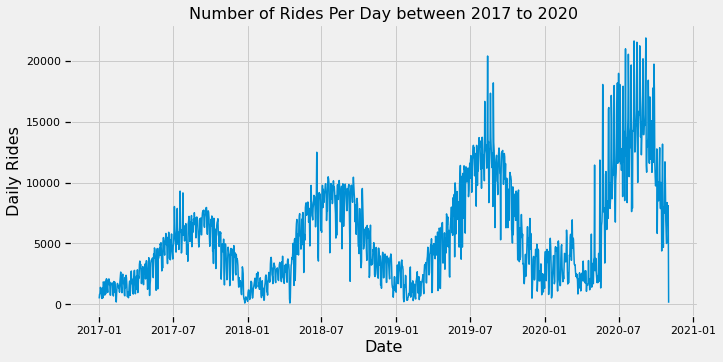

In [12]:
plt.figure(figsize=(10,5))
usage=sns.lineplot(x=df_usage_perd.index,y=df_usage_perd['trip_count'])
usage.axes.set_title("Number of Rides Per Day between 2017 to 2020",
                      fontsize=16)
usage.set_ylabel("Daily Rides",
                  fontsize=16)
usage.set_xlabel("Date",
                  fontsize=16)
plt.show()

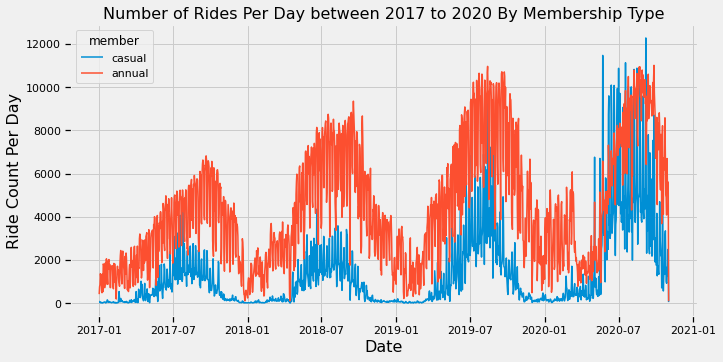

In [13]:
plt.figure(figsize=(10,5))
usage=sns.lineplot(x=df_usage_perd_bymem.index,y=df_usage_perd_bymem['trip_count'], hue=df_usage_perd_bymem['member'])
usage.axes.set_title("Number of Rides Per Day between 2017 to 2020 By Membership Type",
                      fontsize=16)
usage.set_ylabel("Ride Count Per Day",
                  fontsize=16)
usage.set_xlabel("Date",
                  fontsize=16)
plt.show()

Comparisons of Average Daily Rides by Month shows that there is increasing trend of usage from 2017 to 2020, particularly between May and October. The trend is not as obvious during the colder months between November and April. 

Text(0.5, 0, 'Month')

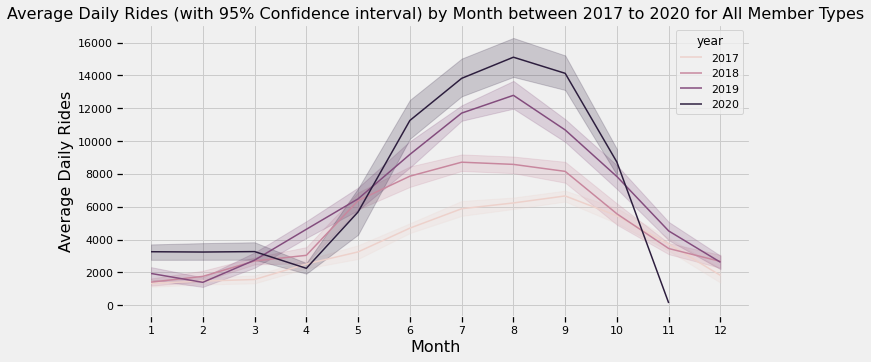

In [14]:
import matplotlib.ticker as ticker

plt.figure(figsize=(10,5))
usage2=sns.lineplot(data=df_usage_perd, x="month", y="trip_count", hue="year", err_style = 'band', ci=95)
usage2.axes.set_title("Average Daily Rides (with 95% Confidence interval) by Month between 2017 to 2020 for All Member Types",
                      fontsize=16)
usage2.xaxis.set_major_locator(ticker.MultipleLocator(1))
usage2.set_ylabel("Average Daily Rides",
                  fontsize=16)
usage2.set_xlabel("Month",
                  fontsize=16)

Text(0.5, 0, 'Month')

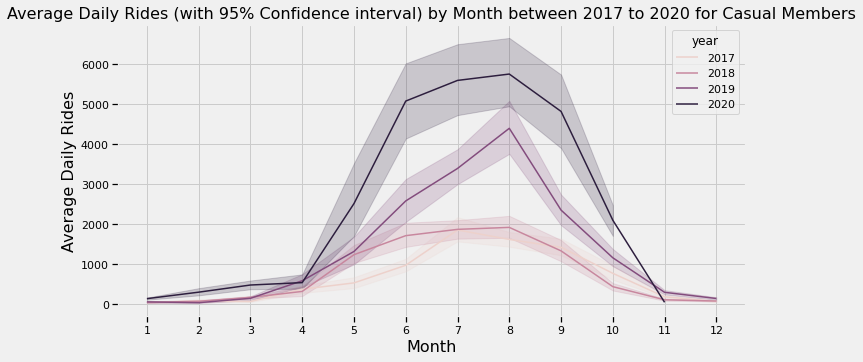

In [23]:
plt.figure(figsize=(10,5))
usage2=sns.lineplot(data=df_usage_perd_casual, x="month", y="trip_count", hue="year", err_style = 'band', ci=95)
usage2.axes.set_title("Average Daily Rides (with 95% Confidence interval) by Month between 2017 to 2020 for Casual Members",
                      fontsize=16)
usage2.xaxis.set_major_locator(ticker.MultipleLocator(1))
usage2.set_ylabel("Average Daily Rides",
                  fontsize=16)
usage2.set_xlabel("Month",
                  fontsize=16)

Text(0.5, 0, 'Month')

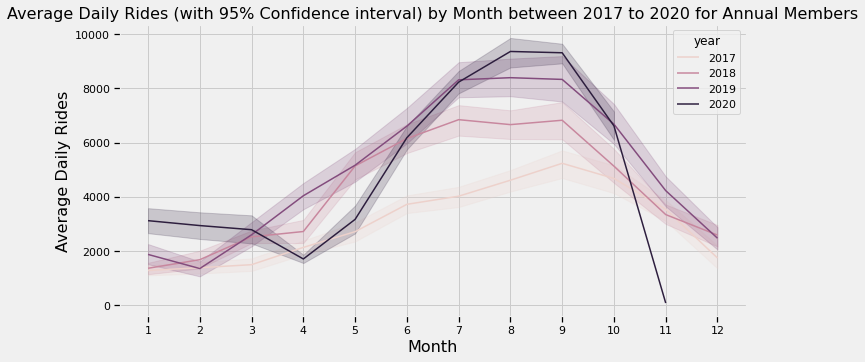

In [24]:
plt.figure(figsize=(10,5))
usage2=sns.lineplot(data=df_usage_perd_annual, x="month", y="trip_count", hue="year", err_style = 'band', ci=95)
usage2.axes.set_title("Average Daily Rides (with 95% Confidence interval) by Month between 2017 to 2020 for Annual Members",
                      fontsize=16)
usage2.xaxis.set_major_locator(ticker.MultipleLocator(1))
usage2.set_ylabel("Average Daily Rides",
                  fontsize=16)
usage2.set_xlabel("Month",
                  fontsize=16)

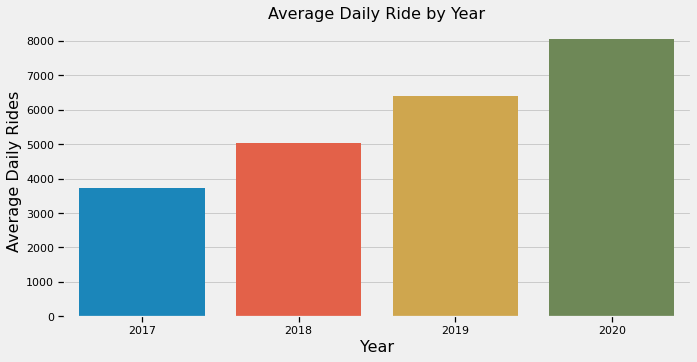

In [17]:
#Plot showing the average daily rides by year for casual and annual members
df_usage_pery=df_usage_perd.groupby('year').agg(annual_trip_count=('trip_count',"sum"), avg_trip_per_day=('trip_count',"mean"))


plt.figure(figsize=(10,5))
ax = sns.barplot(x=df_usage_pery.index, y=df_usage_pery.avg_trip_per_day)
ax.axes.set_title("Average Daily Ride by Year",
                      fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Average Daily Rides",
                  fontsize=16)
plt.show()

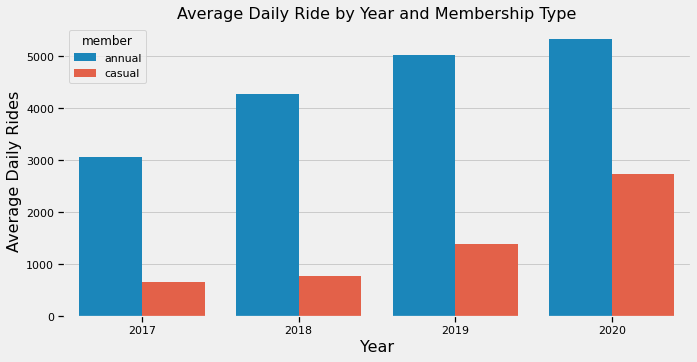

In [43]:
#Plot showing the average daily rides by year for casual and annual members
df_usage_pery_bymem=df_usage_perd_bymem.groupby(['year','member']).agg(annual_trip_count=('trip_count',"sum"), avg_trip_per_day=('trip_count',"mean"))
df_usage_pery_bymem = df_usage_pery_bymem.reset_index()


plt.figure(figsize=(10,5))
ax = sns.barplot(x=df_usage_pery_bymem.year, y=df_usage_pery_bymem.avg_trip_per_day, hue=df_usage_pery_bymem.member)
ax.axes.set_title("Average Daily Ride by Year and Membership Type",
                      fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Average Daily Rides",
                  fontsize=16)
plt.show()

# 2. Is there a difference in usage behaviour between Casual and Annual Member riders?

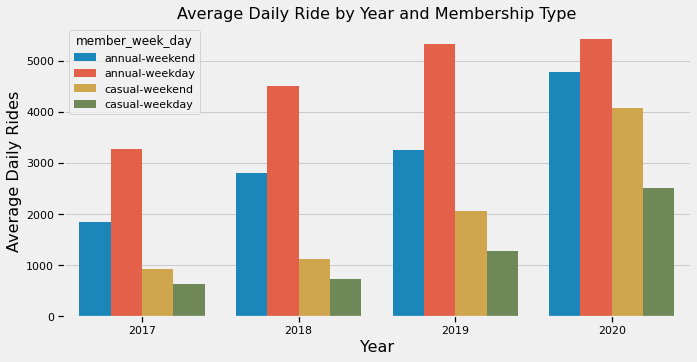

In [55]:
df_usage_perd_bymem['isweek_day'] = df_usage_perd_bymem.index.weekday <6
df_usage_pery_bymem=df_usage_perd_bymem.groupby(['year','member','isweek_day']).agg(annual_trip_count=('trip_count',"sum"), avg_trip_per_day=('trip_count',"mean"))
df_usage_pery_bymem = df_usage_pery_bymem.reset_index()
 
df_usage_pery_bymem.loc[df_usage_pery_bymem['isweek_day'], 'isweek_day'] = 'weekday'
df_usage_pery_bymem.loc[df_usage_pery_bymem['isweek_day'] ==False,'isweek_day'] = 'weekend'



df_usage_pery_bymem['member_week_day'] = df_usage_pery_bymem['member'] +'-'+df_usage_pery_bymem['isweek_day']


plt.figure(figsize=(10,5))
ax = sns.barplot(x=df_usage_pery_bymem.year, y=df_usage_pery_bymem.avg_trip_per_day, hue=df_usage_pery_bymem.member_week_day)
ax.axes.set_title("Average Daily Ride by Year and Membership Type",
                      fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Average Daily Rides",
                  fontsize=16)
plt.show()


### Annual and Causal Rider Tenders
Typically there are more annual riders during the week than the weekend. The inverse is true for the causal riders

## Time of day usage between casual and anual members

In [184]:
df_trips_data['hour'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

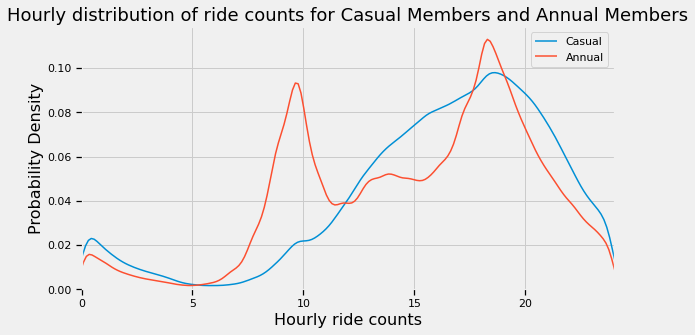

In [188]:
df_trips_data['hour']=[(x.hour+x.minute/60+x.second/60**2) for x in df_trips_data['start_time']]

fig1 = plt.figure(figsize=(8.5,4.5))
ax2 = fig1.subplots()
ax2.set_xlim(0,24)
#map data
sns.distplot(df_trips_data[df_trips_data['user_type'] == 'casual member']['hour'], label = "Casual",ax = ax2, hist = False)
sns.distplot(df_trips_data[df_trips_data['user_type'] == 'annual member']['hour'], label = "Annual",ax = ax2, hist = False)

#formate titles
ax2.set_title("Hourly distribution of ride counts for Casual Members and Annual Members",fontsize = 18)
ax2.set_xlabel("Hourly ride counts", fontsize = 16)
ax2.set_ylabel("Probability Density", fontsize = 16)
ax2.legend()
plt.show()

## 3.  Which neighbourhoods have seen the largest number of rides depart from bike stations located within their boundaries?

## 4. Which neighbourhoods have seen the largest number of rides end at bike stations located within their boundaries?

<ol>
    <li> Import a map of the neighbourhoods </li>
    <li> Determine which station is in which neighboorhood </li>
    <li> Count rides starting in a Neighbourhood </li>
    <li> Generate Heat map of Neighbourhoods and ride start and end locations </li>
</ol>

In [146]:
# Write your code here.
neighbourhoods = gpd.read_file('toronto_neighbourhoods.shp')

# View GeoDataFrame
neighbourhoods.head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,FIELD_12,FIELD_13,FIELD_14,FIELD_15,geometry
0,2101,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
1,2102,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
2,2103,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
3,2104,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),None,None,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
4,2105,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),None,None,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"POLYGON ((-79.43969 43.70561, -79.44011 43.705..."


In [147]:
neighbourhoods['FIELD_8']= neighbourhoods['FIELD_8'].str.split('(', expand = True)
neighbourhoods = neighbourhoods[['geometry', 'FIELD_8']]
neighbourhoods.rename(columns ={'FIELD_8':'neighbourhood'}, inplace = True)
print(neighbourhoods.crs)
neighbourhoods.head()

epsg:4326


,geometry,neighbourhood
0,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",Wychwood
1,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",Yonge-Eglinton
2,"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",Yonge-St.Clair
3,"POLYGON ((-79.50529 43.75987, -79.50488 43.759...",York University Heights
4,"POLYGON ((-79.43969 43.70561, -79.44011 43.705...",Yorkdale-Glen Park


The bikeshare_stations GeoDataFrame does not contain crs information because we contructed it ourselves from (lat,lon) coordinates. However, we know from publicbikesystem.net that the station locations have the same crs as neighbourhoods.

So, let's set the crs of bikeshare_stations_gdf (EPSG:4326).

In [155]:
#aim to analyse the change during each year



#use geopandas to match neighboorhoods to stations

def find_neighboorhood(row):
    for x in range(neighbourhoods.shape[0]):
        if row.within(neighbourhoods.loc[x,'geometry']):
            return neighbourhoods.loc[x,'neighbourhood']
        
def riders_per_neighbourhood_year(stations_info,df_trips,year,df_neighbourhoods):
    df = stations_info.copy()
    df_output = df_neighbourhoods.copy()
    # calc number of trips starting and ending at each stations based on station id
    start = df_trips[df_trips['start_time'].dt.year == year]['start_station_id'].value_counts()
    end = df_trips[df_trips['start_time'].dt.year == year]['end_station_id'].value_counts()
    
    #merge start trip value counts and rename column
    df = pd.merge(df,start, left_on = 'station_id', right_index = True, how = 'inner')
    df.rename(columns = {'start_station_id':'start_ride_count'}, inplace = True)
    
    #merge start trip value counts and rename column
    df = pd.merge(df,end, left_on = 'station_id', right_index = True, how = 'inner')
    df.rename(columns = {'end_station_id':'end_ride_count'}, inplace = True)
    
    #assign to neighbourhoods
    df_output['rides_started'] = df_output.apply(lambda row: df['start_ride_count'][df.within(row.geometry)].sum(), axis = 1)
    df_output['rides_ended'] = df_output.apply(lambda row: df['end_ride_count'][df.within(row.geometry)].sum(), axis = 1)
    #use focus on neighbourhoods with rides starting and ending within the neighbourhoods
    
    return df_output[(df_output['rides_started']>0) | (df_output['rides_ended']>0)]




#######################################################################################

#create a stations dataframe with station name, id and neighbourhood
df_stations = pd.read_csv('bikeshare_stations.csv')
df_stations.columns = [s.replace(' ','_').lower() for s in df_stations.columns ]
df_stations = gpd.GeoDataFrame(df_stations,geometry=gpd.points_from_xy(df_stations['lon'],df_stations['lat']))
df_stations.crs = {'init': 'epsg:4326'}

#assign neighbourhoods
#df_stations['neighbourhood'] = df_stations.apply(lambda row: find_neighboorhood(row.geometry), axis=1 )

#calc for 2017
df_neighbourhood_traffic_2017 = riders_per_neighbourhood_year(df_stations,df_trips_data,2017,neighbourhoods)
df_neighbourhood_traffic_2018 = riders_per_neighbourhood_year(df_stations,df_trips_data,2018,neighbourhoods)
df_neighbourhood_traffic_2019 = riders_per_neighbourhood_year(df_stations,df_trips_data,2019,neighbourhoods)
df_neighbourhood_traffic_2020 = riders_per_neighbourhood_year(df_stations,df_trips_data,2020,neighbourhoods)


df_neighbourhood_traffic_2017.head(100)
print('In 2017 the neighbourhood with the most trips starting within the neighbourhood was:', df_neighbourhood_traffic_2017.sort_values('rides_started',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('In 2017 the neighbourhood with the most trips end within the neighbourhood was:', df_neighbourhood_traffic_2017.sort_values('rides_ended',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('\n')
print('In 2018 the neighbourhood with the most trips starting within the neighbourhood was:', df_neighbourhood_traffic_2018.sort_values('rides_started',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('In 2018 the neighbourhood with the most trips end within the neighbourhood was:', df_neighbourhood_traffic_2018.sort_values('rides_ended',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('\n')
print('In 2019 the neighbourhood with the most trips starting within the neighbourhood was:', df_neighbourhood_traffic_2019.sort_values('rides_started',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('In 2019 the neighbourhood with the most trips end within the neighbourhood was:', df_neighbourhood_traffic_2019.sort_values('rides_ended',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('\n')
print('In 2020 the neighbourhood with the most trips starting within the neighbourhood was:', df_neighbourhood_traffic_2020.sort_values('rides_started',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('In 2020 the neighbourhood with the most trips end within the neighbourhood was:', df_neighbourhood_traffic_2020.sort_values('rides_ended',ascending = False, axis =0)['neighbourhood'].tolist()[0])


In 2017 the neighbourhood with the most trips starting within the neighbourhood was: Waterfront Communities-The Island 
In 2017 the neighbourhood with the most trips end within the neighbourhood was: Waterfront Communities-The Island 


In 2018 the neighbourhood with the most trips starting within the neighbourhood was: Waterfront Communities-The Island 
In 2018 the neighbourhood with the most trips end within the neighbourhood was: Waterfront Communities-The Island 


In 2019 the neighbourhood with the most trips starting within the neighbourhood was: Waterfront Communities-The Island 
In 2019 the neighbourhood with the most trips end within the neighbourhood was: Waterfront Communities-The Island 


In 2020 the neighbourhood with the most trips starting within the neighbourhood was: Waterfront Communities-The Island 
In 2020 the neighbourhood with the most trips end within the neighbourhood was: Waterfront Communities-The Island 


#### Analysis
The trend seems be consitent though out the years so treat the data set as a single data set. 

In [175]:
df_neighbourhoods = neighbourhoods.copy()
# calc number of trips starting and ending at each stations based on station id
start = df_trips_data['start_station_id'].value_counts()
end = df_trips_data['end_station_id'].value_counts()
    
#merge start trip value counts and rename column
df_stations = pd.merge(df_stations,start, left_on = 'station_id', right_index = True, how = 'inner')
df_stations.rename(columns = {'start_station_id':'start_ride_count'}, inplace = True)
    
#merge start trip value counts and rename column
df_stations = pd.merge(df_stations,end, left_on = 'station_id', right_index = True, how = 'inner')
df_stations.rename(columns = {'end_station_id':'end_ride_count'}, inplace = True)

df_neighbourhoods['rides_started_perc'] = np.nan
df_neighbourhoods['rides_ended_perc'] = np.nan


#assign to neighbourhoods
df_neighbourhoods['rides_started_perc'] = df_neighbourhoods.apply(lambda row: df_stations['start_ride_count'][df_stations.within(row.geometry)].sum(), axis = 1)/df_trips_data.shape[0]*100
df_neighbourhoods['rides_ended_perc'] = df_neighbourhoods.apply(lambda row: df_stations['end_ride_count'][df_stations.within(row.geometry)].sum(), axis = 1)/df_trips_data.shape[0]*100
    #use focus on neighbourhoods with rides starting and ending within the neighbourhoods
    
df_neighbourhoods_map = df_neighbourhoods[(df_neighbourhoods['rides_started_perc']>0) | (df_neighbourhoods['rides_ended_perc']>0)]


In [171]:
df_neighbourhoods_map

,geometry,neighbourhood,rides_started,rides_ended
0,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",Wychwood,45026,30770
1,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",Yonge-Eglinton,17594,13161
2,"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",Yonge-St.Clair,6007,4632
3,"POLYGON ((-79.50529 43.75987, -79.50488 43.759...",York University Heights,5295,5258
5,"POLYGON ((-79.50552 43.66281, -79.50577 43.662...",Lambton Baby Point,3237,3245
...,...,...,...,...
125,"POLYGON ((-79.17527 43.78021, -79.17535 43.780...",Highland Creek,112,114
127,"POLYGON ((-79.51329 43.69338, -79.51330 43.692...",Humber Heights-Westmount,931,886
130,"POLYGON ((-79.41849 43.68363, -79.41913 43.683...",Humewood-Cedarvale,1618,1264
133,"POLYGON ((-79.48263 43.66683, -79.48272 43.667...",Junction Area,8175,8330


### Plot the values for each neighbourhood

In [176]:
from folium import Choropleth
from folium import Marker

# Create a base map -79.43592 43.68015
map_3 = folium.Map(location=[43.68015, -79.43592], 
                     tiles='cartodbpositron',
                     zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=df_neighbourhoods_map.__geo_interface__, 
           columns=['neighbourhood', 'rides_started_perc'],
           data=df_neighbourhoods_map,
           key_on='feature.properties.neighbourhood',
           fill_color='YlOrRd', 
           legend_name='Rides Started'
          ).add_to(map_3)

map_3

In [177]:
from folium import Choropleth


# Create a base map 
map_3 = folium.Map(location=[43.68015, -79.43592], 
                     tiles='cartodbpositron',
                     zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=df_neighbourhoods_map.__geo_interface__, 
           columns=['neighbourhood', 'rides_ended_perc'],
           data=df_neighbourhoods_map,
           key_on='feature.properties.neighbourhood',
           fill_color='YlOrRd', 
           legend_name='Rides Started'
          ).add_to(map_3)


map_3